# MobiAct Data Parsing Code

- Data Parsing into similar format with SmartFall dataset
- resampling fall data samples into 30 points and adding 10 ADL samples at the front and the back of the fall data part

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import collections 
import time
from scipy import signal
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
data_dir = "/workspace/inkyung/Fall Detection/MobiAct_dataset/"

"""
- Participants num - 
sub1 ~ sub67

- Fall Types - 
FOL = Fall Foward from standing, use of hands to dampen fall
FKL = Fall Forward from standing, first impact on knees
BSC = Fall Backward while trying to sit on a chair
SDL = Fall Sidewards from standing, bending legs

- ADL Types -
STD = Standing with subtle movements
WAL = Normal Walking
JOG = Jogging
JUM = Continous jumping
STU = Stairs up(10 stairs)
STN = Stairs down(10 stairs)
SCH = Transition from standing to sitting
SIT = Sitting on chair with subtle movements
CHU = Transition from sitting to standing
CSI = Step in a car
CSO = Step out a car
LYI = Activity taken from the lying period after a fall

- 87 Hz mean sampling frequency for the accelerometer
- 200 Hz mean sampling rate for gyroscope and orientation data
"""
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
adl_types = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI']
person_numlist = list(range(1, 68))
trials = list(range(1, 4))

In [3]:
std_len_list, fall_len_list, lyi_len_list = list(), list(), list()
for person_num in tqdm.notebook.tqdm(person_numlist):
    for fall_type in fall_types:
        for trial in trials:
            try:
                directory = data_dir + fall_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)

                std_length = len(data[data['label']=='STD'])
                fall_length = len(data[data['label']==fall_type])
                lyi_length = len(data[data['label']=='LYI'])
                
                std_len_list.append(std_length)
                fall_len_list.append(fall_length)
                lyi_len_list.append(lyi_length)
                
            except FileNotFoundError:
                print(fall_type, person_num, trial, 'no data')

BSC 3 2 no data
FOL 24 1 no data
FOL 24 2 no data
FOL 24 3 no data
FKL 24 1 no data
FKL 24 2 no data
FKL 24 3 no data
BSC 24 1 no data
BSC 24 2 no data
BSC 24 3 no data
SDL 24 1 no data
SDL 24 2 no data
SDL 24 3 no data
FOL 41 1 no data
FOL 41 2 no data
FOL 41 3 no data
FKL 41 1 no data
FKL 41 2 no data
FKL 41 3 no data
BSC 41 1 no data
BSC 41 2 no data
BSC 41 3 no data
SDL 41 1 no data
SDL 41 2 no data
SDL 41 3 no data
FOL 50 1 no data
FOL 50 2 no data
FOL 50 3 no data
FKL 50 1 no data
FKL 50 2 no data
FKL 50 3 no data
BSC 50 1 no data
BSC 50 2 no data
BSC 50 3 no data
SDL 50 1 no data
SDL 50 2 no data
SDL 50 3 no data



In [6]:
print('maximum of STD length is', max(std_len_list))
print('minimum of STD length is', min(std_len_list))
print('average of STD length is', np.mean(np.asarray(std_len_list)))
print('-' * 40)
print('maximum of FALL length is', max(fall_len_list))
print('maximum of FALL length is', min(fall_len_list))
print('maximum of FALL length is', np.mean(np.asarray(fall_len_list)))
print('-' * 40)
print('maximum of LYI length is', max(lyi_len_list))
print('maximum of LYI length is', min(lyi_len_list))
print('maximum of LYI length is', np.mean(np.asarray(lyi_len_list)))

maximum of STD length is 479
minimum of STD length is 6
average of STD length is 157.80573663624511
----------------------------------------
maximum of FALL length is 1061
maximum of FALL length is 222
maximum of FALL length is 483.0299869621904
----------------------------------------
maximum of LYI length is 2261
maximum of LYI length is 790
maximum of LYI length is 1313.084745762712


### Resampling Data

In [8]:
"""
Resampling Fall Data
"""
for person_num in tqdm.notebook.tqdm(person_numlist):
    for fall_type in fall_types:
        for trial in trials:
            try:
                directory = data_dir + fall_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)

                std_length = len(data[data['label']=='STD'])
                fall_length = len(data[data['label']==fall_type])
                lyi_length = len(data[data['label']=='LYI'])
                
                fall_data = data[std_length : std_length + fall_length]
                df = fall_data[['acc_x', 'acc_y', 'acc_z']]

                n = 10
                resampling_size = 30
                
                # For few cases where the length of STD is shorter than 10
                if std_length >= n:
                    # 10 samples from STD + FALL resampled into 30 samples + 10 samples from LYI
                    # acc_x
                    std_x = pd.DataFrame(data['acc_x'][std_length - n : std_length])
                    fall_x = pd.DataFrame(signal.resample(df['acc_x'], resampling_size))
                    fall_x.columns = ['acc_x']
                    lyi_x = pd.DataFrame(data['acc_x'][fall_length : fall_length + n])
                    result = pd.concat([std_x, fall_x, lyi_x], axis=0)
                    
                    # acc_y
                    std_y = pd.DataFrame(data['acc_y'][std_length - n : std_length])
                    fall_y = pd.DataFrame(signal.resample(df['acc_y'], resampling_size))
                    fall_y.columns = ['acc_y']
                    lyi_y = pd.DataFrame(data['acc_y'][fall_length : fall_length + n])
                    result['acc_y'] = pd.concat([std_y, fall_y, lyi_y])
                    
                    # acc_z
                    std_z = pd.DataFrame(data['acc_z'][std_length - n : std_length])
                    fall_z = pd.DataFrame(signal.resample(df['acc_z'], resampling_size))
                    fall_z.columns = ['acc_z']
                    lyi_z = pd.DataFrame(data['acc_z'][fall_length : fall_length + n])
                    result['acc_z'] = pd.concat([std_z, fall_z, lyi_z])
                    
                    # newly indexing
                    result.index = list(range(0, len(result)))

                    result['label'] = 0   #initialzing for label
                    result.loc[n: n + resampling_size - 1, 'label'] = 1    # labelling as 'FALL' = 1
                
                # If the length of STD is shorter than 10
                else:
                    # STD + FALL resampled into 30 samples + 10 samples from LYI
                    # acc_x
                    std_x = pd.DataFrame(data['acc_x'][: std_length])
                    fall_x = pd.DataFrame(signal.resample(df['acc_x'], resampling_size))
                    fall_x.columns = ['acc_x']
                    lyi_x = pd.DataFrame(data['acc_x'][fall_length : fall_length + n + (n - std_length)])
                    result = pd.concat([std_x, fall_x, lyi_x], axis=0)
                    
                    #acc_y
                    std_y = pd.DataFrame(data['acc_y'][: std_length])
                    fall_y = pd.DataFrame(signal.resample(df['acc_y'], resampling_size))
                    fall_y.columns = ['acc_y']
                    lyi_y = pd.DataFrame(data['acc_y'][fall_length : fall_length + n + (n - std_length)])
                    result['acc_y'] = pd.concat([std_y, fall_y, lyi_y])
                    
                    #acc_z
                    std_z = pd.DataFrame(data['acc_z'][: std_length])
                    fall_z = pd.DataFrame(signal.resample(df['acc_z'], resampling_size))
                    fall_z.columns = ['acc_z']
                    lyi_z = pd.DataFrame(data['acc_z'][fall_length : fall_length + n + (n - std_length)])
                    result['acc_z'] = pd.concat([std_z, fall_z, lyi_z])
                    
                    #newly indexing
                    result.index = list(range(0, len(result)))
                    
                    result['label'] = 0   #initialzing for label
                    result.loc[std_length:std_length + resampling_size - 1, 'label'] = 1    # labelling as 'FALL' = 1
                    
                # saving resampled data
                save_route = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/fall/" + fall_type + '_' + str(person_num) + '_' + str(trial) +'.csv'
                result.to_csv(save_route)
            except FileNotFoundError:
                print(fall_type, person_num, trial, 'no data')

BSC 3 2 no data
FOL 24 1 no data
FOL 24 2 no data
FOL 24 3 no data
FKL 24 1 no data
FKL 24 2 no data
FKL 24 3 no data
BSC 24 1 no data
BSC 24 2 no data
BSC 24 3 no data
SDL 24 1 no data
SDL 24 2 no data
SDL 24 3 no data
FOL 41 1 no data
FOL 41 2 no data
FOL 41 3 no data
FKL 41 1 no data
FKL 41 2 no data
FKL 41 3 no data
BSC 41 1 no data
BSC 41 2 no data
BSC 41 3 no data
SDL 41 1 no data
SDL 41 2 no data
SDL 41 3 no data
FOL 50 1 no data
FOL 50 2 no data
FOL 50 3 no data
FKL 50 1 no data
FKL 50 2 no data
FKL 50 3 no data
BSC 50 1 no data
BSC 50 2 no data
BSC 50 3 no data
SDL 50 1 no data
SDL 50 2 no data
SDL 50 3 no data



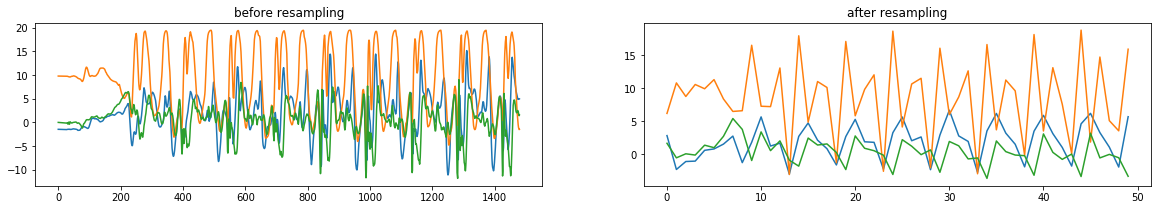

In [16]:
ex = pd.read_csv(data_dir+'JOG_47_1_annotated.csv')
length = len(ex) // 4
plt.figure(figsize=(20,3))
plt.subplot(1, 2, 1)
plt.plot(ex['acc_x'][:length])
plt.plot(ex['acc_y'][:length])
plt.plot(ex['acc_z'][:length])
plt.title('before resampling')

plt.subplot(1, 2, 2)
plt.plot(signal.resample(ex['acc_x'][:length], 50))
plt.plot(signal.resample(ex['acc_y'][:length], 50))
plt.plot(signal.resample(ex['acc_z'][:length], 50))
plt.title('after resampling')
plt.show()

In [17]:
"""
Resampling ADL Data
"""
for person_num in tqdm.notebook.tqdm(person_numlist):
    for adl_type in adl_types:
        for trial in trials:
            try:
                directory = data_dir + adl_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)
                
                length = len(data) // 4
                
                # acc_x
                result = pd.DataFrame(signal.resample(data['acc_x'][:length], 50))
                result.columns = ['acc_x']
                
                #zacc_y
                result['acc_y'] = pd.DataFrame(signal.resample(data['acc_y'][:length], 50))
                
                # acc_z
                result['acc_z'] = pd.DataFrame(signal.resample(data['acc_z'][:length], 50))
                
                # reindexing
                result.index = list(range(0, 50))
                
                result['label'] = 0
                
                # saving resampled data
                save_route = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/adl/" + adl_type + '_' + str(person_num) + '_' + str(trial) +'.csv'
                result.to_csv(save_route)
            except:
                print(adl_type, person_num, trial, 'no data')

STD 1 2 no data
STD 1 3 no data
WAL 1 2 no data
WAL 1 3 no data
SIT 1 2 no data
SIT 1 3 no data
LYI 1 1 no data
LYI 1 2 no data
LYI 1 3 no data
STD 2 2 no data
STD 2 3 no data
WAL 2 2 no data
WAL 2 3 no data
SIT 2 2 no data
SIT 2 3 no data
LYI 2 1 no data
LYI 2 2 no data
LYI 2 3 no data
STD 3 2 no data
STD 3 3 no data
WAL 3 2 no data
WAL 3 3 no data
SIT 3 2 no data
SIT 3 3 no data
LYI 3 1 no data
LYI 3 2 no data
LYI 3 3 no data
STD 4 2 no data
STD 4 3 no data
WAL 4 2 no data
WAL 4 3 no data
SIT 4 1 no data
SIT 4 2 no data
SIT 4 3 no data
CHU 4 1 no data
CHU 4 2 no data
CHU 4 3 no data
LYI 4 1 no data
LYI 4 2 no data
LYI 4 3 no data
STD 5 2 no data
STD 5 3 no data
WAL 5 2 no data
WAL 5 3 no data
SIT 5 2 no data
SIT 5 3 no data
LYI 5 1 no data
LYI 5 2 no data
LYI 5 3 no data
STD 6 2 no data
STD 6 3 no data
WAL 6 2 no data
WAL 6 3 no data
SIT 6 2 no data
SIT 6 3 no data
LYI 6 1 no data
LYI 6 2 no data
LYI 6 3 no data
STD 7 2 no data
STD 7 3 no data
WAL 7 2 no data
WAL 7 3 no data
SIT 7 1 